In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import lightgbm as lgbm
import catboost as ctb
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import pickle

from tqdm import tqdm

from utils import load_json
from features import QuarterlyFeatures, QuarterlyDiffFeatures, BaseCompanyFeatures, FeatureMerger
from targets import QuarterlyTarget, QuarterlyDiffTarget
from models import GroupedOOFModel, AnsambleModel, LogExpModel
from pipelines import BasePipeline
from data import SF1Data
from metrics import median_absolute_relative_error
sns.set()

config = load_json("config.json")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_loader = SF1Data(config['sf1_data_path'])
tickers_df = data_loader.load_tickers(
    currency='USD',
    scalemarketcap=['4 - Mid', '5 - Large', '6 - Mega'])
ticker_list = tickers_df['ticker'].unique().tolist()

In [23]:
config['sf1_data_path'] = '../clever_investment_data/cf1_13_01_2021'

In [5]:
columns = ['revenue', 'netinc', 'ncf', 'assets', 'ebitda', 'debt', 'fcf',
           'gp', 'workingcapital', 'cashneq', 'rnd', 'sgna', 'ncfx',
           'divyield', 'currentratio', 'netinccmn']

cat_columns = ['sector', 'sicindustry']

fc1 = QuarterlyFeatures(columns=columns,
                        quarter_counts=[2, 4, 10],
                        max_back_quarter=10)

fc2 = BaseCompanyFeatures(cat_columns=cat_columns)

fc3 = QuarterlyDiffFeatures(columns=columns,
                            compare_idxs=[1, 4],
                            max_back_quarter=10)

feature = FeatureMerger(fc1, fc2, on='ticker')

feature = FeatureMerger(feature, fc3, on=['ticker', 'date'])


#target = QuarterlyTarget(col='marketcap', quarter_shift=0)
target = QuarterlyDiffTarget(col='marketcap')

base_model = AnsambleModel(base_models=[LogExpModel(lgbm.sklearn.LGBMRegressor()),
                                        LogExpModel(ctb.CatBoostRegressor(verbose=False))], 
                           bagging_fraction=0.7, model_cnt=20)

model = GroupedOOFModel(ctb.CatBoostRegressor(verbose=False),
                        group_column='ticker', fold_cnt=5)

mc_pipeline = BasePipeline(fc3, target, model, median_absolute_relative_error)
mc_pipeline.fit(config, ticker_list)
mc_pipeline.export_core('models_data/diff')

3874it [00:05, 718.99it/s]
2401it [00:03, 673.83it/s]
2401it [00:03, 637.76it/s]


0.7785512312687274


In [ ]:
0.7667987731362407
0.7691278337267149

In [133]:
fc3 = QuarterlyDiffFeatures(columns=columns,
                            compare_idxs=[1, 4],
                            max_back_quarter=10)

In [136]:
X1 = fc1.calculate(config['sf1_data_path'], ticker_list)

3874it [00:29, 132.25it/s]


In [134]:
X3 = fc3.calculate(config['sf1_data_path'], ticker_list)

3874it [00:05, 683.08it/s]


In [135]:
X3

compare1_revenue  compare1_netinc  compare1_ncf  \
ticker date                                                          
DQWS   2020-11-13          0.130347        -6.462092     -1.237010   
       2020-08-14         -0.581247        -1.170664     -1.366247   
       2020-05-15          1.745984        -0.862081      0.817242   
       2020-04-03          0.000000        -0.000000      0.000000   
       2020-03-30          4.015377         6.674380     -2.043553   
...                             ...              ...           ...   
AVIR   2020-12-10               NaN              NaN           NaN   
       2020-10-26               NaN              NaN           NaN   
LESL   2021-02-08         -0.619719        -1.719480     -7.485742   
       2020-12-23               NaN              NaN           NaN   
       2020-10-26               NaN              NaN           NaN   

                   compare1_assets  compare1_ebitda  compare1_debt  \
ticker date                                                          
DQWS   2020-11-13         0.237491        -0.710485      -0.032675   
       2020-08-14        -0.182246         1.668250      -0.102025   
       2020-05-15        -0.020634        -1.367230       0.086086   
       2020-04-03         0.000000        -0.000000       0.000000   
       2020-03-30         0.492856        19.243189       2.479416   
...                            ...              ...            ...   
AVIR   2020-12-10        -0.080496              NaN            NaN   
       2020-10-26         4.424954              NaN            NaN   
LESL   2021-02-08         0.000898        -1.347203      -0.271499   
       2020-12-23         0.269385              NaN       0.152346   
       2020-10-26         0.225777              NaN      -0.003108   

                   compare1_fcf  compare1_gp  compare1_workingcapital  \
ticker date                                                             
DQWS   2020-11-13     -1.343356     0.793755                 0.144819   
       2020-08-14     -1.501061    -0.574071                -0.149388   
       2020-05-15     -3.339641     1.272454                -0.033306   
       2020-04-03     -0.000000     0.000000                -0.000000   
       2020-03-30     -0.451716     4.745730                 1.060454   
...                         ...          ...                      ...   
AVIR   2020-12-10           NaN          NaN                -0.123842   
       2020-10-26           NaN          NaN                 4.719743   
LESL   2021-02-08    -10.690949    -0.689649                 0.428474   
       2020-12-23           NaN          NaN                -0.121351   
       2020-10-26           NaN          NaN                 0.112433   

                   compare1_cashneq  ...  compare4_fcf  compare4_gp  \
ticker date                          ...                              
DQWS   2020-11-13          0.069348  ...     -1.402517     0.736181   
       2020-08-14         -0.226362  ...     -0.357245     4.561310   
       2020-05-15          1.618204  ...      3.586985     5.350196   
       2020-04-03          0.000000  ...     -0.647455     3.873477   
       2020-03-30          0.139890  ...      0.108555     3.453074   
...                             ...  ...           ...          ...   
AVIR   2020-12-10         -0.089894  ...           NaN          NaN   
       2020-10-26          4.345644  ...           NaN          NaN   
LESL   2021-02-08         -0.337393  ...           NaN          NaN   
       2020-12-23          0.054875  ...           NaN          NaN   
       2020-10-26          0.638093  ...           NaN          NaN   

                   compare4_workingcapital  compare4_cashneq  compare4_rnd  \
ticker date                                                                  
DQWS   2020-11-13                -0.058636          1.166008           NaN   
       2020-08-14                 0.694273          1.308895           NaN   
       2020

In [ ]:
pd.merge(X1, X3, h)

In [137]:
X1

quarter2_revenue_mean  quarter2_revenue_median  \
ticker date                                                         
DQWS   2020-11-13               235307.5                 235307.5   
       2020-08-14               374226.0                 374226.0   
       2020-05-15               359828.0                 359828.0   
       2020-04-03               192114.0                 192114.0   
       2020-03-30               115209.5                 115209.5   
...                                  ...                      ...   
AVIR   2020-12-10                    0.0                      0.0   
       2020-10-26                    NaN                      NaN   
LESL   2021-02-08            263159500.0              263159500.0   
       2020-12-23            381313000.0              381313000.0   
       2020-10-26                    NaN                      NaN   

                   quarter2_revenue_max  quarter2_revenue_min  \
ticker date                                                     
DQWS   2020-11-13              249705.0              220910.0   
       2020-08-14              527542.0              220910.0   
       2020-05-15              527542.0              192114.0   
       2020-04-03              192114.0              192114.0   
       2020-03-30              192114.0               38305.0   
...                                 ...                   ...   
AVIR   2020-12-10                   0.0                   0.0   
       2020-10-26                   NaN                   NaN   
LESL   2021-02-08           381313000.0           145006000.0   
       2020-12-23           381313000.0           381313000.0   
       2020-10-26                   NaN                   NaN   

                   quarter2_revenue_std  quarter2_revenue_diff_mean  \
ticker date                                                           
DQWS   2020-11-13               14397.5                     28795.0   
       2020-08-14              153316.0                   -306632.0   
       2020-05-15              167714.0                    335428.0   
       2020-04-03                   0.0                         0.0   
       2020-03-30               76904.5                    153809.0   
...                                 ...                         ...   
AVIR   2020-12-10                   0.0                         NaN   
       2020-10-26                   NaN                         NaN   
LESL   2021-02-08           118153500.0                -236307000.0   
       2020-12-23                   0.0                         NaN   
       2020-10-26                   NaN                         NaN   

                   quarter2_revenue_diff_median  quarter2_revenue_diff_max  \
ticker date                                                                  
DQWS   2020-11-13                       28795.0                    28795.0   
       2020-08-14                     -306632.0                  -306632.0   
       2020-05-15                      335428.0                   335428.0   
       2020-04-03                           0.0                        0.0   
       2020-03-30                      153809.0                   153809.0   
...                                         ...                        ...   
AVIR   2020-12-10                           NaN                        NaN   
       2020-10-26                           NaN                        NaN   
LESL   2021-02-08                  -236307000.0               -236307000.0   
       2020-12-23                           NaN                        NaN   
       2020-10-26                           NaN                        NaN   

                   quarter2_revenue_diff_min  quarter2_revenue_diff_std  ...  \
ticker date                                                              ...   
DQWS   2020-11-13                    28795.0                        0.0  ...   
       2020-08-14                  -306632.0                        0.0  ...   
       2020-05-1

In [ ]:
0.3238006278631045 ans
0.3226811547779296 log_exp_ctb
0.34013409255339005 log_exp_lgb
0.3731881490521315 ctb
0.38325054127451996 lgb

In [91]:
pred = mc_pipeline.core['model'].predict(X)

In [26]:
model = GroupedOOFModel(ctb.CatBoostRegressor(verbose=False), group_column='ticker', fold_cnt=5)


In [89]:
X = feature.calculate(config['sf1_data_path'], ticker_list)
y = target.calculate(config['sf1_data_path'], 
                                  X.index.to_frame(index=False))
leave_mask = (y['y'].isnull() == False)
y = y[leave_mask]#.reset_index(drop=True)
X = X[leave_mask]

3874it [00:27, 138.80it/s]
2401it [00:03, 676.29it/s]


In [90]:
y['y']

ticker  date      
DQWS    2020-11-13    2.484924e+09
        2020-08-14    1.758689e+09
        2020-05-15    4.138092e+08
        2020-04-03    4.138092e+08
        2020-03-30    7.903756e+08
                          ...     
ALGM    2021-02-02    6.063774e+09
        2020-11-20    4.317150e+09
AVIR    2020-12-10    2.341364e+09
LESL    2021-02-08    5.183866e+09
        2020-12-23    5.256697e+09
Name: y, Length: 19928, dtype: float64

In [92]:
gt = y['y'].values
mask = gt != 0
pred = pred[mask]
gt = gt[mask]
np.abs((gt - pred) / gt).mean()



0.8765481321714902

In [126]:
np.median(np.abs((gt - pred) / gt))


0.3226811547779296

In [104]:
np.median(arr)


0.31166043869552296

In [105]:
arr.mean()

0.42742603372275134

In [124]:
arr = np.abs((gt - pred) / gt)
arr = arr[gt > 1 * 1e9]

In [122]:
arr.mean()

0.36785569356512554

In [125]:
np.median(arr)

0.2950889951081395

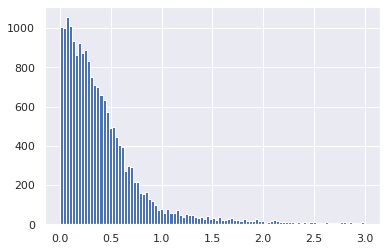

In [100]:
arr = np.abs((gt - pred) / gt)
arr = arr[arr < 3]
plt.hist(arr, bins=100)
plt.show()

In [ ]:
0.862784225388626

In [ ]:
0.849212706649981
0.8797120056717131

In [146]:
X = feature.calculate(config['sf1_data_path'], ticker_list)

3874it [00:29, 133.37it/s]


In [147]:
y = target.calculate(config['sf1_data_path'],
                     X[['ticker', 'date']])

2401it [00:04, 574.02it/s]
2401it [00:04, 538.85it/s]


In [148]:
leave_mask =  (y['y'].isnull() == False)

In [149]:
y = y[leave_mask].reset_index(drop=True)
X = X[leave_mask].reset_index(drop=True)

In [150]:
y['pred'] = mc_pipeline.core['model'].predict(X=X.drop(['ticker', 'date'], axis=1), groups=X['ticker'])

In [167]:
y['metric'] = np.abs(y['y'] - y['pred'] ) / np.abs(y['y'])
y['metric'] = y['metric'].replace([np.inf, -np.inf], np.nan)

In [168]:
y.dropna().sort_values('metric', ascending=False)[:]

,ticker,date,y,pred,metric
12119,WAFD,2020-08-07,-4.757153e-07,0.199354,419062.105646
8718,CAVM,2016-08-08,3.055497e-06,0.134959,44168.336746
8492,JAZZ,2019-05-07,-5.625809e-06,0.032723,5817.570311
4534,INTEQ,2020-08-06,5.065505e-05,-0.244287,4823.550591
16069,FFBC,2020-02-21,4.206644e-06,-0.011944,2840.406427
...,...,...,...,...,...
2030,INVH,2020-10-29,-7.650667e-02,-0.076464,0.000559
6488,WES2,2017-02-23,1.746206e-01,0.174704,0.000477
7790,HUN,2020-05-01,-2.722570e-01,-0.272170,0.000319
16130,LM,2020-05-29,2.610481e-01,0.261117,0.000263


In [176]:
y['metric'].median()

0.7691278337267149

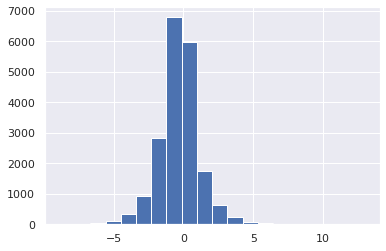

In [172]:
plt.hist(np.log(y['metric']), bins=20)
plt.show()

In [11]:
ticker_list[24]

'SKLZ'

In [69]:
data = SF1Data(config['sf1_data_path']).load_quarterly_data(['AAPL'])  

In [5]:
columns = config['pipelines']['marketcap']['quarter_columns']

In [29]:
(np.abs(y['y'] - pred) / y['y']).median()

0.3297666545251804

In [30]:
(np.abs(y['y'] - pred) / y['y']).mean()

0.8797120056717131

In [227]:
X = X.set_index(['ticker', 'date'])

In [185]:
y = y.set_index(['ticker', 'date'])

In [215]:
X.reset_index(inplace=True)

In [234]:
X.reset_index()['ticker']

0        DQWS
1        DQWS
2        DQWS
3        DQWS
4        DQWS
         ... 
19763    LSPD
19764    FROG
19765    STEP
19766    ALGM
19767    LESL
Name: ticker, Length: 19768, dtype: object

In [236]:
pd.merge(X, X, on=['ticker', 'date'], how='left')

quarter2_revenue_mean_x  quarter2_revenue_median_x  \
ticker date                                                             
DQWS   2020-11-13                 235307.5                   235307.5   
       2020-08-14                 374226.0                   374226.0   
       2020-05-15                 359828.0                   359828.0   
       2020-04-03                 192114.0                   192114.0   
       2020-03-30                 115209.5                   115209.5   
...                                    ...                        ...   
LSPD   2021-02-04               51552000.0                 51552000.0   
FROG   2021-02-12               40787500.0                 40787500.0   
STEP   2021-02-11              245031500.0                245031500.0   
ALGM   2021-02-02              150549000.0                150549000.0   
LESL   2021-02-08              263159500.0                263159500.0   

                   quarter2_revenue_max_x  quarter2_revenue_min_x  \
ticker date                                                         
DQWS   2020-11-13                249705.0                220910.0   
       2020-08-14                527542.0                220910.0   
       2020-05-15                527542.0                192114.0   
       2020-04-03                192114.0                192114.0   
       2020-03-30                192114.0                 38305.0   
...                                   ...                     ...   
LSPD   2021-02-04              57611000.0              45493000.0   
FROG   2021-02-12              42689000.0              38886000.0   
STEP   2021-02-11             247150000.0             242913000.0   
ALGM   2021-02-02             164449000.0             136649000.0   
LESL   2021-02-08             381313000.0             145006000.0   

                   quarter2_revenue_std_x  quarter2_revenue_diff_mean_x  \
ticker date                                                               
DQWS   2020-11-13                 14397.5                       28795.0   
       2020-08-14                153316.0                     -306632.0   
       2020-05-15                167714.0                      335428.0   
       2020-04-03                     0.0                           0.0   
       2020-03-30                 76904.5                      153809.0   
...                                   ...                           ...   
LSPD   2021-02-04               6059000.0                    12118000.0   
FROG   2021-02-12               1901500.0                     3803000.0   
STEP   2021-02-11               2118500.0                     4237000.0   
ALGM   2021-02-02              13900000.0                    27800000.0   
LESL   2021-02-08             118153500.0                  -236307000.0   

                   quarter2_revenue_diff_median_x  \
ticker date                                         
DQWS   2020-11-13                         28795.0   
       2020-08-14                       -306632.0   
       2020-05-15                        335428.0   
       2020-04-03                             0.0   
       2020-03-30                        153809.0   
...                                           ...   
LSPD   2021-02-04                      12118000.0   
FROG   2021-02-12                       3803000.0   
STEP   2021-02-11                       4237000.0   
ALGM   2021-02-02                      27800000.0   
LESL   2021-02-08                    -236307000.0   

                   quarter2_revenue_diff_max_x  quarter2_revenue_diff_min_x  \
ticker date                                                                   
DQWS   2020-11-13                      28795.0                      28795.0   
       2020-08-14                    -306632.0                    -306632.0   
       2020-05-15                     335428.0                     335428.0   
       2020-04-03                          0.0                          0.0   
       2020-03-30              

In [218]:
X['date'] = X['date'].apply(lambda x: np.datetime64(x))

In [225]:
X['sicindustry'] = X['sicindustry'] > 0

In [226]:
X.dtypes

ticker                                  object
date                            datetime64[ns]
quarter2_revenue_mean                  float64
quarter2_revenue_median                float64
quarter2_revenue_max                   float64
                                     ...      
quarter10_netinccmn_diff_max           float64
quarter10_netinccmn_diff_min           float64
quarter10_netinccmn_diff_std           float64
sector                                   int64
sicindustry                               bool
Length: 484, dtype: object

In [224]:
ctb.CatBoostRegressor(verbose=False).fit(X.drop(['ticker'], axis=1), y['y'])

In [191]:
time = X.reset_index()['date'].apply(lambda x: np.datetime64(x)).values

In [204]:
%%time
max(time)

CPU times: user 30.5 ms, sys: 0 ns, total: 30.5 ms
Wall time: 30.5 ms


numpy.datetime64('2021-02-18T00:00:00.000000000')

In [196]:
delta

numpy.timedelta64(29496960000000000,'ns')

In [207]:
fold_cnt = 20

max_time = max(time)
min_time = min(time)
delta = (max_time - min_time) // fold_cnt

time_bounds = []
for fold_id in range(1, fold_cnt):
    time_bounds.append(min_time + fold_id * delta)

In [211]:
time[time <= time_bounds[0]]

array(['2016-08-08T00:00:00.000000000', '2016-07-29T00:00:00.000000000',
       '2016-08-05T00:00:00.000000000', '2016-08-05T00:00:00.000000000',
       '2016-08-05T00:00:00.000000000', '2016-08-12T00:00:00.000000000',
       '2016-08-11T00:00:00.000000000', '2016-08-11T00:00:00.000000000',
       '2016-08-02T00:00:00.000000000', '2016-07-26T00:00:00.000000000',
       '2016-08-05T00:00:00.000000000', '2016-08-11T00:00:00.000000000',
       '2016-08-09T00:00:00.000000000', '2016-08-05T00:00:00.000000000',
       '2016-08-04T00:00:00.000000000', '2016-07-28T00:00:00.000000000',
       '2016-08-04T00:00:00.000000000', '2016-09-09T00:00:00.000000000',
       '2016-08-03T00:00:00.000000000', '2016-08-08T00:00:00.000000000',
       '2016-08-05T00:00:00.000000000', '2016-07-29T00:00:00.000000000',
       '2016-08-04T00:00:00.000000000', '2016-08-02T00:00:00.000000000',
       '2016-09-09T00:00:00.000000000', '2016-08-08T00:00:00.000000000',
       '2016-08-04T00:00:00.000000000', '2016-07-28

In [209]:
len(time_bounds)

19

In [208]:
time_bounds

[numpy.datetime64('2016-09-10T08:24:00.000000000'),
 numpy.datetime64('2016-12-04T16:48:00.000000000'),
 numpy.datetime64('2017-02-28T01:12:00.000000000'),
 numpy.datetime64('2017-05-24T09:36:00.000000000'),
 numpy.datetime64('2017-08-17T18:00:00.000000000'),
 numpy.datetime64('2017-11-11T02:24:00.000000000'),
 numpy.datetime64('2018-02-04T10:48:00.000000000'),
 numpy.datetime64('2018-04-30T19:12:00.000000000'),
 numpy.datetime64('2018-07-25T03:36:00.000000000'),
 numpy.datetime64('2018-10-18T12:00:00.000000000'),
 numpy.datetime64('2019-01-11T20:24:00.000000000'),
 numpy.datetime64('2019-04-07T04:48:00.000000000'),
 numpy.datetime64('2019-07-01T13:12:00.000000000'),
 numpy.datetime64('2019-09-24T21:36:00.000000000'),
 numpy.datetime64('2019-12-19T06:00:00.000000000'),
 numpy.datetime64('2020-03-13T14:24:00.000000000'),
 numpy.datetime64('2020-06-06T22:48:00.000000000'),
 numpy.datetime64('2020-08-31T07:12:00.000000000'),
 numpy.datetime64('2020-11-24T15:36:00.000000000')]

In [186]:
X.join(y)

quarter2_revenue_mean  quarter2_revenue_median  \
ticker date                                                         
DQWS   2020-11-13               235307.5                 235307.5   
       2020-08-14               374226.0                 374226.0   
       2020-05-15               359828.0                 359828.0   
       2020-04-03               192114.0                 192114.0   
       2020-03-30               115209.5                 115209.5   
...                                  ...                      ...   
LSPD   2021-02-04             51552000.0               51552000.0   
FROG   2021-02-12             40787500.0               40787500.0   
STEP   2021-02-11            245031500.0              245031500.0   
ALGM   2021-02-02            150549000.0              150549000.0   
LESL   2021-02-08            263159500.0              263159500.0   

                   quarter2_revenue_max  quarter2_revenue_min  \
ticker date                                                     
DQWS   2020-11-13              249705.0              220910.0   
       2020-08-14              527542.0              220910.0   
       2020-05-15              527542.0              192114.0   
       2020-04-03              192114.0              192114.0   
       2020-03-30              192114.0               38305.0   
...                                 ...                   ...   
LSPD   2021-02-04            57611000.0            45493000.0   
FROG   2021-02-12            42689000.0            38886000.0   
STEP   2021-02-11           247150000.0           242913000.0   
ALGM   2021-02-02           164449000.0           136649000.0   
LESL   2021-02-08           381313000.0           145006000.0   

                   quarter2_revenue_std  quarter2_revenue_diff_mean  \
ticker date                                                           
DQWS   2020-11-13               14397.5                     28795.0   
       2020-08-14              153316.0                   -306632.0   
       2020-05-15              167714.0                    335428.0   
       2020-04-03                   0.0                         0.0   
       2020-03-30               76904.5                    153809.0   
...                                 ...                         ...   
LSPD   2021-02-04             6059000.0                  12118000.0   
FROG   2021-02-12             1901500.0                   3803000.0   
STEP   2021-02-11             2118500.0                   4237000.0   
ALGM   2021-02-02            13900000.0                  27800000.0   
LESL   2021-02-08           118153500.0                -236307000.0   

                   quarter2_revenue_diff_median  quarter2_revenue_diff_max  \
ticker date                                                                  
DQWS   2020-11-13                       28795.0                    28795.0   
       2020-08-14                     -306632.0                  -306632.0   
       2020-05-15                      335428.0                   335428.0   
       2020-04-03                           0.0                        0.0   
       2020-03-30                      153809.0                   153809.0   
...                                         ...                        ...   
LSPD   2021-02-04                    12118000.0                 12118000.0   
FROG   2021-02-12                     3803000.0                  3803000.0   
STEP   2021-02-11                     4237000.0                  4237000.0   
ALGM   2021-02-02                    27800000.0                 27800000.0   
LESL   2021-02-08                  -236307000.0               -236307000.0   

                   quarter2_revenue_diff_min  quarter2_revenue_diff_std  ...  \
ticker date                                                              ...   
DQWS   2020-11-13                    28795.0                        0.0  ...   
       2020-08-14                  -306632.0                        0.0  ...   
       2020-05-1

In [182]:
pd.merge(X, y, on='ticker', how='left')

,ticker,quarter2_revenue_mean,quarter2_revenue_median,quarter2_revenue_max,quarter2_revenue_min,quarter2_revenue_std,quarter2_revenue_diff_mean,quarter2_revenue_diff_median,quarter2_revenue_diff_max,quarter2_revenue_diff_min,...,quarter10_netinccmn_diff_median,quarter10_netinccmn_diff_max,quarter10_netinccmn_diff_min,quarter10_netinccmn_diff_std,sector,sicindustry,date,y,pred,metric
0,DQWS,235307.5,235307.5,249705.0,220910.0,14397.5,28795.0,28795.0,28795.0,28795.0,...,10495.0,95618.0,-56532.0,4.359313e+04,3,195,2020-11-13,0.412941,1.188729,1.878689
1,DQWS,235307.5,235307.5,249705.0,220910.0,14397.5,28795.0,28795.0,28795.0,28795.0,...,10495.0,95618.0,-56532.0,4.359313e+04,3,195,2020-08-14,3.250000,1.764145,0.457186
2,DQWS,235307.5,235307.5,249705.0,220910.0,14397.5,28795.0,28795.0,28795.0,28795.0,...,10495.0,95618.0,-56532.0,4.359313e+04,3,195,2020-05-15,0.000000,1.227492,NaN
3,DQWS,235307.5,235307.5,249705.0,220910.0,14397.5,28795.0,28795.0,28795.0,28795.0,...,10495.0,95618.0,-56532.0,4.359313e+04,3,195,2020-04-03,-0.476440,0.927045,2.945775
4,DQWS,235307.5,235307.5,249705.0,220910.0,14397.5,28795.0,28795.0,28795.0,28795.0,...,10495.0,95618.0,-56532.0,4.359313e+04,3,195,2020-03-30,0.469231,1.287880,1.744661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172697,LSPD,51552000.0,51552000.0,57611000.0,45493000.0,6059000.0,12118000.0,12118000.0,12118000.0,12118000.0,...,-23185000.0,-23185000.0,-23185000.0,0.000000e+00,10,307,2021-02-04,0.841238,0.180177,0.785819
172698,FROG,40787500.0,40787500.0,42689000.0,38886000.0,1901500.0,3803000.0,3803000.0,3803000.0,3803000.0,...,1551000.0,1551000.0,1551000.0,0.000000e+00,10,307,2021-02-12,0.023568,0.060123,1.551090
172699,STEP,245031500.0,245031500.0,247150000.0,242913000.0,2118500.0,4237000.0,4237000.0,4237000.0,4237000.0,...,41015500.0,55663000.0,26368000.0,1.464750e+07,5,121,2021-02-11,0.322992,0.112765,0.650873
172700,ALGM,150549000.0,150549000.0,164449000.0,136649000.0,13900000.0,27800000.0,27800000.0,27800000.0,27800000.0,...,-4957500.0,4764000.0,-14679000.0,9.721500e+06,10,263,2021-02-02,0.404578,0.067306,0.833638


In [181]:
y

,ticker,date,y,pred,metric
0,DQWS,2020-11-13,0.412941,1.188729,1.878689
1,DQWS,2020-08-14,3.250000,1.764145,0.457186
2,DQWS,2020-05-15,0.000000,1.227492,NaN
3,DQWS,2020-04-03,-0.476440,0.927045,2.945775
4,DQWS,2020-03-30,0.469231,1.287880,1.744661
...,...,...,...,...,...
19763,LSPD,2021-02-04,0.841238,0.180177,0.785819
19764,FROG,2021-02-12,0.023568,0.060123,1.551090
19765,STEP,2021-02-11,0.322992,0.112765,0.650873
19766,ALGM,2021-02-02,0.404578,0.067306,0.833638


In [18]:
y = y[leave_mask].reset_index(drop=True)
X = X[leave_mask].reset_index(drop=True)

mc_pipeline._eval(X=X.drop(['ticker', 'date'], axis=1),
           y=y['y'].values,
           groups=X['ticker'])     

nan


In [ ]:
0.39497680805725816

In [17]:
mc_pipeline.export_core('models_data/diff')

In [6]:
imp_df = pd.DataFrame()
imp_df['column'] = mc_pipeline.model.columns
imp_df['importance'] = mc_pipeline.model.base_models[0].feature_importances_
imp_df = imp_df.sort_values('importance', ascending=False)[:]
imp_df[:10]

,column,importance
135,quarter2_divyield_diff_mean,40
134,quarter2_divyield_std,38
481,sicindustry,34
145,quarter2_currentratio_diff_mean,32
105,quarter2_rnd_diff_mean,32
256,quarter4_cashneq_diff_median,31
44,quarter2_ebitda_std,30
84,quarter2_workingcapital_std,27
404,quarter10_workingcapital_std,24
465,quarter10_currentratio_diff_mean,24


In [11]:
mc_pipeline = BasePipeline.load('models_data/ctb.pickle')
mc_df = mc_pipeline.execute(config, ticker_list)

In [8]:
mc_df

,ticker,date,y
0,DQWS,2020-11-13,4.195258e+09
1,DQWS,2020-08-14,4.008153e+09
2,DQWS,2020-05-15,4.053623e+09
3,DQWS,2020-04-03,4.149051e+09
4,DQWS,2020-03-30,4.065268e+09
...,...,...,...
20071,AVIR,2020-12-10,7.639594e+09
20072,AVIR,2020-10-26,1.071128e+10
20073,LESL,2021-02-08,2.427790e+09
20074,LESL,2020-12-23,7.391225e+09
